Dataset shape: (12020, 2)


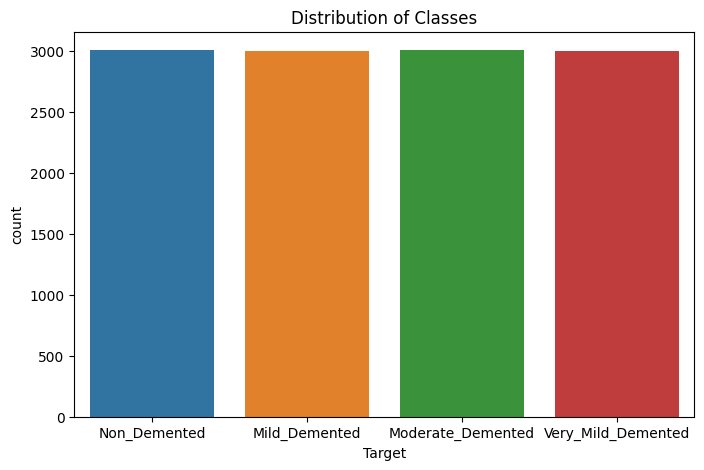

Found 9616 validated image filenames belonging to 4 classes.
Found 2404 validated image filenames belonging to 4 classes.


In [2]:
import os
import glob
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Model
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet,VGG16,VGG19, MobileNetV2, ResNet50, ResNet101,ResNet152, InceptionV3,InceptionResNetV2,DenseNet121,DenseNet169,DenseNet201,Xception,NASNetMobile, NASNetLarge
from keras.applications.inception_v3 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix

DATA_PATH = "/kaggle/input/preprocess-dataset-augmentation/AD_AUG"
def load_data(data_path):
    all_paths = glob.glob(f'{data_path}/**/*.*', recursive=True)
    labels = [os.path.split(os.path.split(path)[0])[1] for path in all_paths]
    return pd.DataFrame({'Filepath': all_paths, 'Target': labels}).sample(frac=1).reset_index(drop=True)

dataframe = load_data(DATA_PATH)
def explore_data(df):
    print("Dataset shape:", df.shape)
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x='Target')
    plt.title("Distribution of Classes")
    plt.show()
dataframe = load_data(DATA_PATH)
explore_data(dataframe)
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preprocessing: Grayscale,Denoising,CLAHE,Resize,Rescale
#Local Binary Pattern (LBP) for feature extraction

def preprocess_image(filepath):

    image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

    image = cv2.fastNlMeansDenoising(image, None, 10, 7, 21)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image = clahe.apply(image)

    image = cv2.resize(image, (128, 128))

    image = image / 255.0

    lbp = local_binary_pattern(image, P=8, R=1, method="uniform")

    return lbp
def prepare_data(df):

    datagen = ImageDataGenerator(validation_split=0.2)

    def custom_image_loader(filepath):
        processed_image = preprocess_image(filepath)
        return np.expand_dims(processed_image, axis=-1)

    train_data = datagen.flow_from_dataframe(
        df, x_col='Filepath', y_col='Target', target_size=(128, 128), batch_size=16, subset='training',
        class_mode='categorical', shuffle=True,
        preprocessing_function=custom_image_loader
    )
    test_data = datagen.flow_from_dataframe(
        df, x_col='Filepath', y_col='Target', target_size=(128, 128), batch_size=16, subset='validation',
        class_mode='categorical', shuffle=False,
        preprocessing_function=custom_image_loader
    )

    return train_data, test_data


train_data, test_data = prepare_data(dataframe)
 

Dataset shape: (12020, 2)


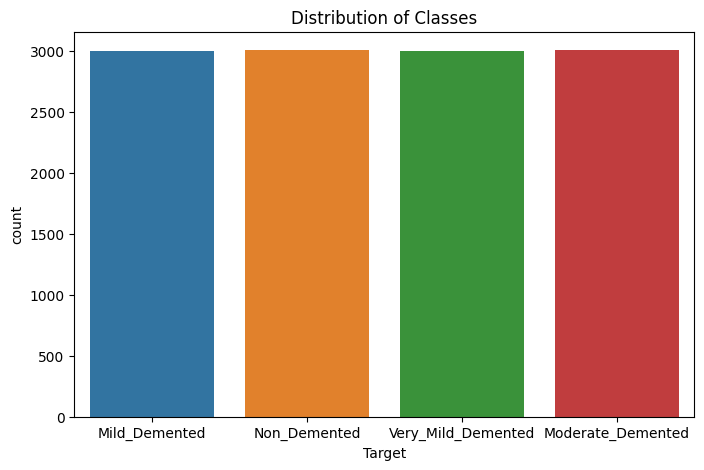

Found 9616 validated image filenames belonging to 4 classes.
Found 2404 validated image filenames belonging to 4 classes.
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (None, 1, 2048)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 1, 256)              │       2,360,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 128)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 26,162,180 (99.80 MB)

 Trainable params: 2,574,468 (9.82 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 48s 66ms/step - accuracy: 0.3981 - loss: 1.2417 - val_accuracy: 0.7600 - val_loss: 0.6214 - learning_rate: 1.0000e-04
Epoch 2/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 38s 62ms/step - accuracy: 0.7332 - loss: 0.6423 - val_accuracy: 0.8856 - val_loss: 0.3282 - learning_rate: 1.0000e-04
Epoch 3/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 38s 62ms/step - accuracy: 0.8477 - loss: 0.4061 - val_accuracy: 0.9172 - val_loss: 0.2396 - learning_rate: 1.0000e-04
Epoch 4/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 37s 62ms/step - accuracy: 0.8892 - loss: 0.3080 - val_accuracy: 0.9131 - val_loss: 0.2398 - learning_rate: 1.0000e-04
Epoch 5/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 38s 62ms/step - accuracy: 0.9066 - loss: 0.2567 - val_accuracy: 0.9443 - val_loss: 0.1477 - learning_rate: 1.0000e-04
Epoch 6/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 38s 62ms/step - accuracy: 0.9215 - loss: 0.2134 - val_accuracy: 0.9447 - val_loss: 0.1444 - learning_rate: 1.0000e-04
Epoch 7/50
601/601 ━━━━━━━━━━━━━━━━━━━━ 38s 62ms/ste

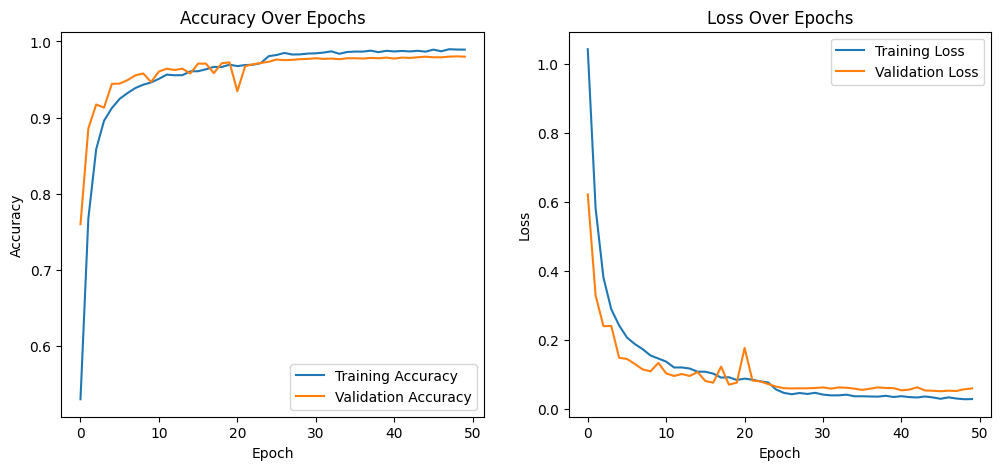

In [5]:
import os
import glob
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Model
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Reshape, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import cv2
from skimage.feature import local_binary_pattern
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define data path
DATA_PATH = "/kaggle/input/preprocess-dataset-augmentation/AD_AUG"

# Load data
def load_data(data_path):
    all_paths = glob.glob(f'{data_path}/**/*.*', recursive=True)
    labels = [os.path.split(os.path.split(path)[0])[1] for path in all_paths]
    return pd.DataFrame({'Filepath': all_paths, 'Target': labels}).sample(frac=1).reset_index(drop=True)

# Explore data
def explore_data(df):
    print("Dataset shape:", df.shape)
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x='Target')
    plt.title("Distribution of Classes")
    plt.show()

# Load and explore data
dataframe = load_data(DATA_PATH)
explore_data(dataframe)

# Preprocessing: Grayscale, Denoising, CLAHE, Resize, Rescale, LBP
def preprocess_image(filepath):
    # Load image as grayscale
    image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    
    # Denoise
    image = cv2.fastNlMeansDenoising(image, None, 10, 7, 21)
    
    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image = clahe.apply(image)
    
    # Resize
    image = cv2.resize(image, (224, 224))  # ResNet50 expects 224x224
    
    # Rescale
    image = image / 255.0
    
    # Convert to 3 channels (ResNet50 expects 3 channels)
    image = np.stack((image,)*3, axis=-1)
    
    return image

# Prepare data
def prepare_data(df):
    datagen = ImageDataGenerator(validation_split=0.2)

    def custom_image_loader(filepath):
        processed_image = preprocess_image(filepath)
        return processed_image

    train_data = datagen.flow_from_dataframe(
        df, x_col='Filepath', y_col='Target', target_size=(224, 224), batch_size=16, subset='training',
        class_mode='categorical', shuffle=True, preprocessing_function=custom_image_loader
    )
    test_data = datagen.flow_from_dataframe(
        df, x_col='Filepath', y_col='Target', target_size=(224, 224), batch_size=16, subset='validation',
        class_mode='categorical', shuffle=False, preprocessing_function=custom_image_loader
    )

    return train_data, test_data

# Prepare data
train_data, test_data = prepare_data(dataframe)

# Define the custom model
def create_custom_model(input_shape, num_classes):
    # Load pre-trained ResNet50 (without top layers)
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze the base model
    base_model.trainable = False

    # Add custom layers
    model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Reshape((-1, 2048)),  # Reshape for LSTM
        LSTM(256, return_sequences=True),
        Dropout(0.5),
        LSTM(128),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)  # ResNet50 expects 224x224 with 3 channels
num_classes = len(train_data.class_indices)

# Create the model
model = create_custom_model(input_shape, num_classes)

# Print model summary
model.summary()

# Callbacks to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)

# Train the model
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=50,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc:.4f}")

# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

151/151 ━━━━━━━━━━━━━━━━━━━━ 10s 52ms/step
Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented       0.96      0.97      0.96       607
 Moderate_Demented       1.00      1.00      1.00       597
      Non_Demented       1.00      1.00      1.00       589
Very_Mild_Demented       0.97      0.95      0.96       611

          accuracy                           0.98      2404
         macro avg       0.98      0.98      0.98      2404
      weighted avg       0.98      0.98      0.98      2404



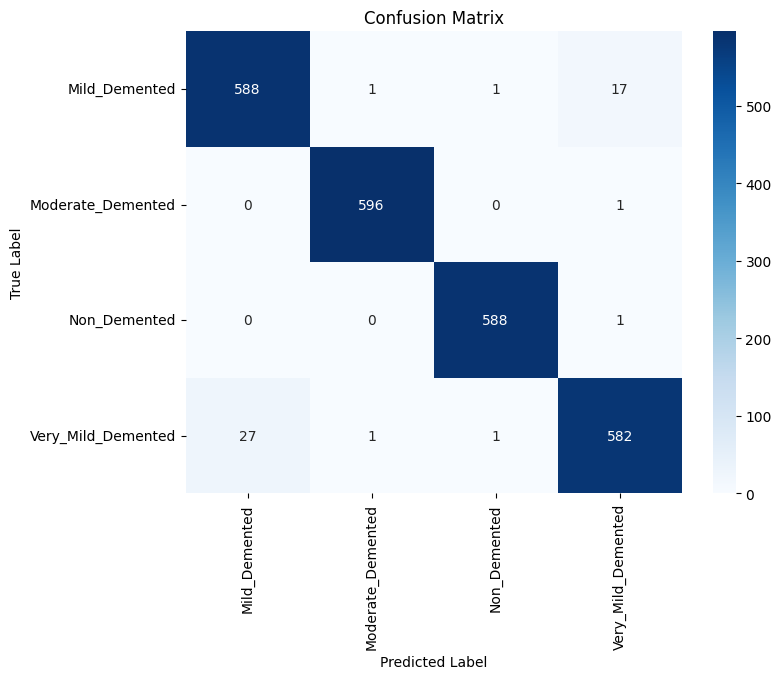

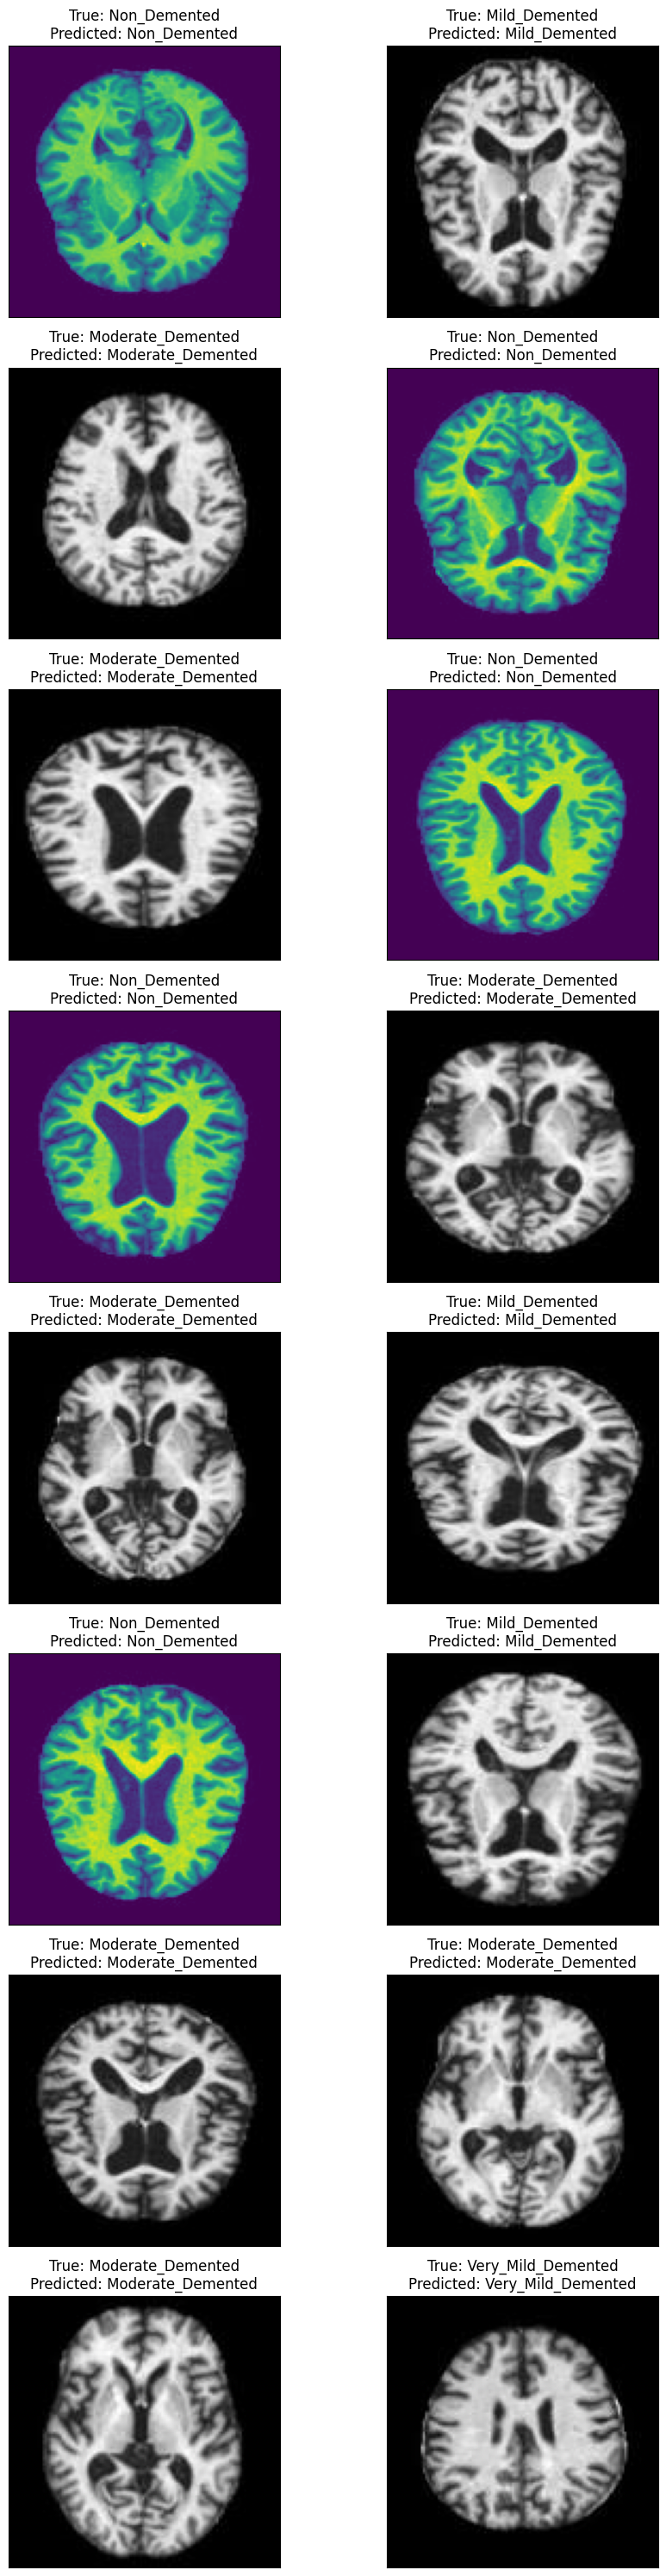

In [6]:
# Classification Report and Confusion Matrix
true_labels = test_data.classes
pred = np.argmax(model.predict(test_data), axis=1)

print("Classification Report:")
print(classification_report(true_labels, pred, target_names=test_data.class_indices.keys()))

cm = confusion_matrix(true_labels, pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_data.class_indices.keys(),
            yticklabels=test_data.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Display Random Images with Predictions
filepaths = test_data.filepaths
class_indices = test_data.class_indices
class_labels = {v: k for k, v in class_indices.items()}

true_label_names = [class_labels[label] for label in true_labels]
pred_label_names = [class_labels[label] for label in pred]

# Randomly select images to display
random_indices = random.sample(range(len(filepaths)), min(16, len(filepaths)))

fig, axes = plt.subplots(nrows=8, ncols=2, figsize=(10, 30), subplot_kw={'xticks': [], 'yticks': []})
axes = axes.flatten()

for i, idx in enumerate(random_indices):
    img = plt.imread(filepaths[idx])  # Read the image
    true_label = true_label_names[idx]
    pred_label = pred_label_names[idx]

    axes[i].imshow(img)
    axes[i].set_title(f"True: {true_label}\nPredicted: {pred_label}")

plt.tight_layout()
plt.show()
